In [ ]:
!conda activate openvino_env
!set PATH=C:\Users\SuperSoso1\.conda\envs\openvino_env\Lib\site-packages\openvino\libs;%PATH%
!cd C:\Users\SuperSoso1\Cranfield/GDP/pose_dongzi
!jupyter notebook poose.ipynb

#!pip install openvino --user

In [1]:
# %load MovenetMPOpenvino.py

import numpy as np
from collections import namedtuple
import cv2
from pathlib import Path
from FPS import FPS, now
import argparse
import os
from openvino.inference_engine import IENetwork, IECore
from Tracker import TrackerIoU, TrackerOKS, TRACK_COLORS
from IPython.display import Image
import cv2 as cv
import math
from shapely.geometry import Point,Polygon,LineString
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Returns f{-1}(y)
def f_inv(y,a,b):
    x = (y - b)/a
    return x

In [3]:
#Returns f(x)
def f(x,a,b) : 
    y = a * x + b  
    return y

In [4]:
#Rotation matrix with an angle of alpha
def rotation(alpha) :
    return np.array([[np.cos(alpha), np.sin(alpha)],[-np.sin(alpha), np.cos(alpha)]])

In [5]:
#MoveNet : keypoint detection model
DEFAULT_MODEL =  "models/movenet_multipose_lightning_192x256_FP32.xml"
#"models/movenet_multipose_lightning_736x1280_FP32.xml"
img_folder='images2'


KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Each line is a list of keypoints as defined at https://github.com/tensorflow/tfjs-models/tree/master/pose-detection#keypoint-diagram
LINES_BODY = [[4,2],[2,0],[0,1],[1,3],
            [10,8],[8,6],[6,5],[5,7],[7,9],
            [6,12],[12,11],[11,5],
            [12,14],[14,16],[11,13],[13,15]]

#Definition of the Body
class Body:
    def __init__(self, score, xmin, ymin, xmax, ymax, keypoints_score, keypoints, keypoints_norm):
        self.score = score # global score
        # xmin, ymin, xmax, ymax : bounding box
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.keypoints_score = keypoints_score# scores of the keypoints
        self.keypoints_norm = keypoints_norm # keypoints normalized ([0,1]) coordinates (x,y) in the input image
        self.keypoints = keypoints # keypoints coordinates (x,y) in pixels in the input image

    def print(self):
        attrs = vars(self)
        print('\n'.join("%s: %s" % item for item in attrs.items()))

    def str_bbox(self):
        return f"xmin={self.xmin} xmax={self.xmax} ymin={self.ymin} ymax={self.ymax}"

# Padding (all values are in pixel) :
# w (resp. h): horizontal (resp. vertical) padding on the source image to make its ratio same as Movenet model input. 
#               The padding is done on one side (bottom or right) of the image.
# padded_w (resp. padded_h): width (resp. height) of the image after padding
Padding = namedtuple('Padding', ['w', 'h', 'padded_w',  'padded_h'])

#Initialisation of input in MoveNet model
class MovenetMPOpenvino:
    def __init__(self, input_src="dance.mp4",
                xml=DEFAULT_MODEL, 
                device="CPU",
                tracking=False,
                score_thresh=0.2,
                output='output.mp4'):
        
        self.score_thresh = score_thresh
        self.tracking = tracking
        if tracking is None:
            self.tracking = False
        elif tracking == "iou":
            self.tracking = True
            self.tracker = TrackerIoU()
        elif tracking == "oks":
            self.tracking = True
            self.tracker = TrackerOKS()
         
        if input_src.endswith('.jpg') or input_src.endswith('.png') :
            self.input_type= "image"
            self.img = cv2.imread(input_src)
            self.video_fps = 25
            self.img_h, self.img_w = self.img.shape[:2]
        else :
            self.input_type = "video"
            if input_src.isdigit():
                input_type = "webcam"
                input_src = int(input_src)
                
                
            self.cap = cv2.VideoCapture(input_src)
            self.video_fps = int(self.cap.get(cv2.CAP_PROP_FPS))
            self.img_w = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            print(self.img_w)
            self.img_h = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        print("Video FPS:", self.video_fps)
    
        # Load Openvino models
        self.load_model(xml, device)     

        # Rendering flags
        self.show_fps = True
        self.show_bounding_box = True

        if output is None: 
            self.output = None
        else:
            if self.input_type == "image":
                # For an source image, we will output one image (and not a video) and exit
                self.output = output
            else:
                
                #fourcc = cv2.VideoWriter_fourcc(*"MJPG")
                self.output = cv2.VideoWriter(output,cv2.VideoWriter_fourcc(*'mp4v'),self.video_fps,(self.img_w, self.img_h)) 

        # Define the padding
        # Note we don't center the source image. The padding is applied
        # on the bottom or right side. That simplifies a bit the calculation
        # when depadding
        if self.img_w / self.img_h > self.pd_w / self.pd_h:
            pad_h = int(self.img_w * self.pd_h / self.pd_w - self.img_h)
            self.padding = Padding(0, pad_h, self.img_w, self.img_h + pad_h)
        else:
            pad_w = int(self.img_h * self.pd_w / self.pd_h - self.img_w)
            self.padding = Padding(pad_w, 0, self.img_w + pad_w, self.img_h)
        print("Padding:", self.padding)
        
    def load_model(self, xml_path, device):

        print("Loading Inference Engine")
        self.ie = IECore()
        print("Device info:")
        versions = self.ie.get_versions(device)
        print("{}{}".format(" "*8, device))
        print("{}MKLDNNPlugin version ......... {}.{}".format(" "*8, versions[device].major, versions[device].minor))
        print("{}Build ........... {}".format(" "*8, versions[device].build_number))

        name = os.path.splitext(xml_path)[0]
        bin_path = name + '.bin'
        print("Pose Detection model - Reading network files:\n\t{}\n\t{}".format(xml_path, bin_path))
        self.pd_net = self.ie.read_network(model=xml_path, weights=bin_path)
        # Input blob: input:0 - shape: [1, 3, 256, 256] (lightning)
        # Output blob: Identity - shape: [1, 6, 56]
        self.pd_input_blob = next(iter(self.pd_net.input_info))
        print(f"Input blob: {self.pd_input_blob} - shape: {self.pd_net.input_info[self.pd_input_blob].input_data.shape}")
        _,_,self.pd_h,self.pd_w = self.pd_net.input_info[self.pd_input_blob].input_data.shape
        for o in self.pd_net.outputs.keys():
            print(f"Output blob: {o} - shape: {self.pd_net.outputs[o].shape}")
        self.pd_kps = "Identity"
        print("Loading pose detection model into the plugin")
        self.pd_exec_net = self.ie.load_network(network=self.pd_net, num_requests=1, device_name=device)

        self.infer_nb = 0
        self.infer_time_cumul = 0

    #Pad and resize the image to prepare for the model input
    def pad_and_resize(self, frame):
        
        padded = cv2.copyMakeBorder(frame, 
                                        0, 
                                        self.padding.h,
                                        0, 
                                        self.padding.w,
                                        cv2.BORDER_CONSTANT)

        padded = cv2.resize(padded, (self.pd_w, self.pd_h), interpolation=cv2.INTER_AREA)
        return padded

    #Body structure
    def pd_postprocess(self, inference):
        result = np.squeeze(inference[self.pd_kps]) # 6x56
        bodies = []
        for i in range(6):
            kps = result[i][:51].reshape(17,-1)
            bbox = result[i][51:55].reshape(2,2)          
            score = result[i][55]
            if score > self.score_thresh:
                ymin, xmin, ymax, xmax = (bbox * [self.padding.padded_h, self.padding.padded_w]).flatten().astype(np.int)
                kp_xy =kps[:,[1,0]]
                keypoints = kp_xy * np.array([self.padding.padded_w, self.padding.padded_h])

                body = Body(score=score, xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax, 
                            keypoints_score = kps[:,2], 
                            keypoints = keypoints.astype(np.int),
                            keypoints_norm = keypoints / np.array([self.img_w, self.img_h]))
                bodies.append(body)
        return bodies
        
    #Function of keypoints, skeleton and bounding box plotting
    def pd_render(self, frame, bodies):  
        thickness = 1
        color_skeleton = (255, 180, 90)
        color_box = (0,255,255)
        
        firstframe = cv.imread("first_frame.jpg")

        H = firstframe.shape[0]
        W = firstframe.shape[1] 
        
        x = np.linspace(0,W,num = 500)
        y = np.linspace(0,H,num = 500)

        for body in bodies:
            if self.tracking:
                color_skeleton = color_box = TRACK_COLORS[body.track_id % len(TRACK_COLORS)]
            
            #Skeleton
            lines = [np.array([body.keypoints[point] for point in line]) for line in LINES_BODY if body.keypoints_score[line[0]] > self.score_thresh and body.keypoints_score[line[1]] > self.score_thresh]
            cv2.polylines(frame, lines, False, color_skeleton, 1, cv2.LINE_AA)
            
            #print("---")
            xmin=body.xmin
            xmax=body.xmax
            ymin=body.ymin
            ymax=body.ymax
          
            #Keypoints
            for i,x_y in enumerate(body.keypoints):
                if body.keypoints_score[i] > self.score_thresh:
                    if i % 2 == 1:
                        color = (0,255,0) 
                    elif i == 0:
                        color = (0,255,255)
                    else:
                        color = (0,0,255)
                    cv2.circle(frame, (x_y[0], x_y[1]), 2, color, -11)
            
            #Bounding box
            if self.show_bounding_box:
                cv2.rectangle(frame, (body.xmin, body.ymin), (body.xmax, body.ymax), color_box, thickness)

            if self.tracking:
                # Display track_id at the center of the bounding box
                x_mid = (body.xmin + body.xmax) // 2
                y_mid = (body.ymin + body.ymax) // 2
                cv2.putText(frame, str(body.track_id), (x_mid,y_mid), cv2.FONT_HERSHEY_PLAIN, 4, color_box, 3)
          
        
            #Computation and plot of the rotated ellipse
            Neck = np.mean(body.keypoints[5:7,:],axis=0).reshape(1,2)[0]
            Hips = np.mean(body.keypoints[11:13,:],axis=0).reshape(1,2)[0]
            
            average_keypoints = np.concatenate((Neck,Hips),axis=0).reshape(2,2)
            
            coeff_vertical_rot = np.polyfit(average_keypoints[:,0], average_keypoints[:,1], 1)
            vertical_rot = f_inv(y,coeff_vertical_rot[0],coeff_vertical_rot[1])

            alpha = np.radians(90) - math.atan(coeff_vertical_rot[0])
    
            center_coordinates = (np.int64(Hips[0]), np.int64(Hips[1])) 
            if (xmax - xmin) <= (ymax - ymin) :
                axesLength = (np.int64((xmax - xmin)/2), np.int64((ymax - ymin)/2)) 
            else :
                axesLength = (np.int64((ymax - ymin)/2), np.int64((xmax - xmin)/2)) 

            angle = -np.round(np.degrees(alpha),2)
            color = (0, 0, 255) #BGR
            thickness = 1
            startAngle = 0
            endAngle = 360
            cv2.ellipse(frame, center_coordinates, axesLength, angle, startAngle, endAngle, color, thickness)
    
            #Computation and plot of regions
            x1 = (W/2)*np.sqrt(1 - ((y - H/2)/(H/2))**2) + W/2

            leftline = rotation(np.radians(45))@np.array([(Hips[0]*np.ones(len(x1)) - Hips[0]),(y - Hips[1])]) + [np.ones(len(x1))*Hips[0],np.ones(len(x1))*Hips[1]]
            rightline = rotation(np.radians(-45))@np.array([(Hips[0]*np.ones(len(x1)) - Hips[0]),(y - Hips[1])]) + [np.ones(len(x1))*Hips[0],np.ones(len(x1))*Hips[1]]
            coeff_left = np.polyfit(leftline[0], leftline[1], 1)
            coeff_right = np.polyfit(rightline[0], rightline[1], 1)

            leftline = np.concatenate((x.reshape(-1,1),f(x,coeff_left[0],coeff_left[1]).reshape(-1,1)),axis = 1)
            rightline =  np.concatenate((x.reshape(-1,1),f(x,coeff_right[0],coeff_right[1]).reshape(-1,1)), axis = 1)

            color = (0,0,0)

            cv2.line(frame, (np.int64((np.round(leftline[0,0],0))),np.int64((np.round(leftline[0,1],0)))),(np.int64((np.round(leftline[-1,0],0))),np.int64((np.round(leftline[-1,1],0)))), (0,0,255), thickness=1)
            cv2.line(frame, (np.int64(Hips[0]),np.int64((np.round(y[0],0)))),(np.int64(Hips[0]),np.int64((np.round(y[-1],0)))), color, thickness=1)
            cv2.line(frame, (np.int64((np.round(x[0],0))),np.int64(Hips[1])),(np.int64((np.round(x[-1],0))),np.int64(Hips[1])), color, thickness=1)
            cv2.line(frame, (np.int64((np.round(rightline[0,0],0))),np.int64((np.round(rightline[0,1],0)))),(np.int64((np.round(rightline[-1,0],0))),np.int64((np.round(rightline[-1,1],0)))), (255,0,0), thickness=1)
    
    def run(self):
        print('Started ....')
 
        incnt = 0
        count = 0
        self.fps = FPS()
        nb_pd_inferences = 0
        glob_pd_rtrip_time = 0
        total_bodies = []

        while True:
            if self.input_type == "image":
                frame = self.img.copy()
            else:
                ok, frame = self.cap.read()
                count+=1
                incnt+=1
                
                if not ok:
                    break
                    
            #First frame of the video saved for dimension purposes        
            if count == 1 :
                filename='first_frame.jpg'
                cv2.imwrite(filename, frame)

            padded = self.pad_and_resize(frame)
            # cv2.imshow("Padded", padded)
                
            frame_nn = cv2.cvtColor(padded, cv2.COLOR_BGR2RGB).transpose(2,0,1).astype(np.float32)[None,] 
            pd_rtrip_time = now()
            inference = self.pd_exec_net.infer(inputs={self.pd_input_blob: frame_nn})
            glob_pd_rtrip_time += now() - pd_rtrip_time
            bodies = self.pd_postprocess(inference)
            if self.tracking:
                bodies = self.tracker.apply(bodies, now())
                
            total_bodies.append(bodies)
            
            self.pd_render(frame, bodies)
            nb_pd_inferences += 1
            
            self.fps.update()  
            self.show_fps = True
            
            if self.show_fps:
                self.fps.draw(frame, orig=(50,50), size=1, color=(240,180,100))
            #cv2.imwrite(os.path.join(img_folder, f'{incnt:06d}.png'), frame)
            
            if count>500 and incnt % 100 == 0:
                filename='photo.jpg'
                cv2.imwrite(filename, frame)                                   
                display(Image(filename))
            
            #cv2.imshow("Movenet", frame)
            
            if self.output:
                if self.input_type == "image":
                    cv2.imwrite(self.output, frame)
                    break
                else:
                    self.output.write(frame)

            #key = cv2.waitKey(1) 
            #if key == ord('q') or key == 27:
            #    break
            #elif key == 32:
                # Pause on space bar
            #    cv2.waitKey(0)
            #elif key == ord('f'):
                 #self.show_fps = True
            #elif key == ord('b'):
            #    self.show_bounding_box = not self.show_bounding_box
            
        # Print some stats
        if nb_pd_inferences > 1:
            global_fps, nb_frames = self.fps.get_global()

            print(f"FPS : {global_fps:.1f} f/s (# frames = {nb_frames})")
            print(f"# pose detection inferences : {nb_pd_inferences}")
            print(f"Pose detection round trip   : {glob_pd_rtrip_time/nb_pd_inferences*1000:.1f} ms")

        if self.output and self.input_type != "image":
            #cv2.imwrite(os.path.join(img_folder, f'{incnt:06d}.png'), frame)
                        
            self.output.write(frame)
            self.output.release()
        
        return total_bodies

Example of bounding box, regions, track id and ellipse : 


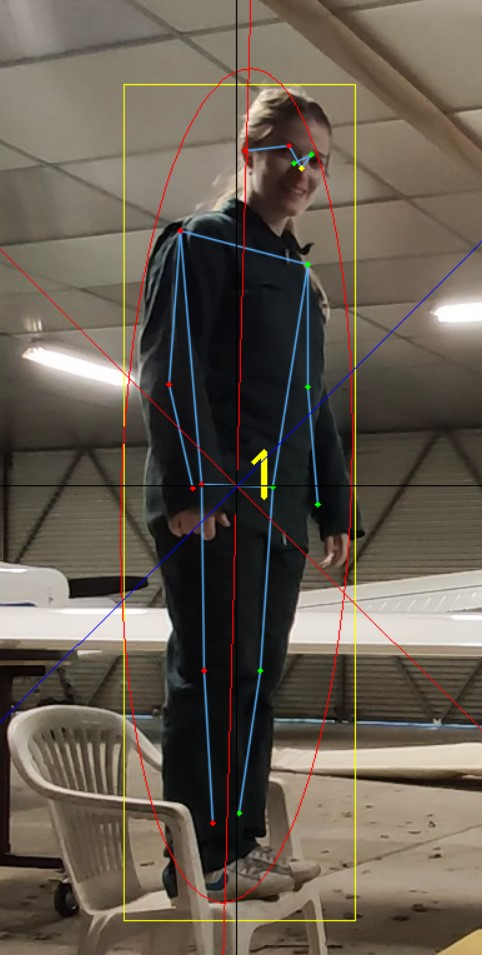

In [6]:
#Image detection
file_name = "example.jpg"
img = cv.imread(file_name)

scale_percent = 50
Width = int(img.shape[1] * scale_percent / 100)
Height = int(img.shape[0] * scale_percent / 100)

print("Example of bounding box, regions, track id and ellipse : ")
Image(filename = file_name, width=Width, height=Height) 

In [7]:
#Region creation in function of the frame dimensions and the diagonals
def Regions(W,H,Hips,rightline,leftline,keypoints,ndh_type) :
    
    #R1 & R2 
    if(rightline[-1,0] == W) : #If the blue diagonal is touching the upper x-limit of the frame
        R1 = [(Hips[0], Hips[1]), (Hips[0], 0), (W, 0), (W, rightline[-1,1])]
        R2 = [(Hips[0], Hips[1]), (W, rightline[-1,1]), (W,Hips[1])]
        
    elif(rightline[-1,1] == 0) : #If the blue diagonal is touching the lower y-limit of the frame
        R1 = [(Hips[0], Hips[1]), (Hips[0], 0), (rightline[-1,0], 0)]
        R2 = [(Hips[0], Hips[1]), (rightline[-1,0], 0), (W, 0), (W,Hips[1])]
        
    else : #If the blue diagonal is exactly going through the right-hand upper corner of the frame
        R1 = [(Hips[0], Hips[1]), (Hips[0], 0), (W, 0)]
        R2 = [(Hips[0], Hips[1]), (W, 0),(W,Hips[1])]

        
    #R3 & R4    
    if(leftline[-1,0] == W) : #If the red diagonal is touching the upper x-limit of the frame
        R3 = [(Hips[0], Hips[1]), (W,Hips[1]), (W,leftline[-1,1])]
        R4 = [(Hips[0], Hips[1]), (W,leftline[-1,1]), (W,H), (Hips[0],H)]
        
    elif(leftline[-1,1] == H) : #If the red diagonal is touching the upper y-limit of the frame
        R3 = [(Hips[0], Hips[1]), (W,Hips[1]), (W,H), (leftline[-1,0],H)]
        R4 = [(Hips[0], Hips[1]), (leftline[-1,0],H), (Hips[0],H)]
        
    else : #If the red diagonal is exactly going through the right-hand lower corner of the frame
        R3 = [(Hips[0], Hips[1]), (W,Hips[1]), (W,H)]
        R4 = [(Hips[0], Hips[1]), (W,H), (Hips[0],H)]

        
    #R5 & R6    
    if(rightline[0,0] == 0) : #If the blue diagonal is touching the lower x-limit of the frame
        R5 = [(Hips[0], Hips[1]), (Hips[0],H), (0,H), (0, rightline[0,1])]
        R6 = [(Hips[0], Hips[1]), (0, rightline[0,1]), (0,Hips[1])]
        
    elif(rightline[0,1] == H) : #If the blue diagonal is touching the upper y-limit of the frame
        R5 = [(Hips[0], Hips[1]), (Hips[0],H), (rightline[0,0],H)]
        R6 = [(Hips[0], Hips[1]), (rightline[0,0],H), (0,H), (0,Hips[1])]
        
    else : #If the blue diagonal is exactly going through the left-hand lower corner of the frame
        R5 = [(Hips[0], Hips[1]), (Hips[0],H), (0,H)]
        R6 = [(Hips[0], Hips[1]), (0,H), (0,Hips[1])]

        
    #R7 & R8   
    if(leftline[0,0] == 0) : #If the red diagonal is touching the lower x-limit of the frame
        R7 = [(Hips[0], Hips[1]), (0,Hips[1]), (0,leftline[0,1])]
        R8 = [(Hips[0], Hips[1]), (0,leftline[0,1]), (0,0), (Hips[0], 0)]

    elif(leftline[0,1] == 0) : #If the red diagonal is touching the lower y-limit of the frame
        R7 = [(Hips[0], Hips[1]), (0,Hips[1]), (0,0), (leftline[0,0],0)]
        R8 = [(Hips[0], Hips[1]), (leftline[0,0],0), (Hips[0], 0)]
        
    else : #If the red diagonal is exactly going through the left-hand upper corner of the frame
        R7 = [(Hips[0], Hips[1]), (0,Hips[1]), (0,0)]
        R8 = [(Hips[0], Hips[1]), (0,0), (Hips[0], 0)]

    #Creation of the polygons composed of the points defined earlier
    poly_R1 = Polygon(R1)
    poly_R2 = Polygon(R2)
    poly_R3 = Polygon(R3)
    poly_R4 = Polygon(R4)
    poly_R5 = Polygon(R5)
    poly_R6 = Polygon(R6)
    poly_R7 = Polygon(R7)
    poly_R8 = Polygon(R8)

    
    
    if ndh_type == 'RegKey' :
        #For every keypoint, we check in which polygon(region) they are contained        
        Nose = keypoints[0,:]
        Neck = np.mean(keypoints[5:7,:],axis=0).reshape(1,2)[0]
        
        keypoints = keypoints[3:,:]
        keypoints[0,:] = Nose
        keypoints[1,:] = Neck
        
        #Matrix containing the keypoints in each region : size = (number of regions, number of keypoints)
        R_key = np.zeros((8,len(keypoints)))
        
        for i in range(len(keypoints)) :
            if(keypoints[i,0] != 0 or keypoints[i,1] != 0) :
                target = Point(keypoints[i,0], keypoints[i,1])
                R_key[0,i] = poly_R1.contains(target)
                R_key[1,i] = poly_R2.contains(target)
                R_key[2,i] = poly_R3.contains(target)
                R_key[3,i] = poly_R4.contains(target) 
                R_key[4,i] = poly_R5.contains(target)
                R_key[5,i] = poly_R6.contains(target)
                R_key[6,i] = poly_R7.contains(target)
                R_key[7,i] = poly_R8.contains(target)

    else :
        #Matrix containing the keypoints in each region : size = (number of regions, number of keypoints)
        R_key = np.zeros((8,len(keypoints)))
        
        for i in range(len(keypoints)) :
            if(keypoints[i,0] != 0 or keypoints[i,1] != 0) :
                target = Point(keypoints[i,0], keypoints[i,1])
                R_key[0,i] = poly_R1.contains(target)
                R_key[1,i] = poly_R2.contains(target)
                R_key[2,i] = poly_R3.contains(target)
                R_key[3,i] = poly_R4.contains(target) 
                R_key[4,i] = poly_R5.contains(target)
                R_key[5,i] = poly_R6.contains(target)
                R_key[6,i] = poly_R7.contains(target)
                R_key[7,i] = poly_R8.contains(target)


    #print(R_key)
    #print(sum(R_key))
    #print(np.sum(R_key, axis = 1))
    
    if ndh_type == 'ndh' :
    #The final NDH is the sum of the columns of the global region matrix
        return np.sum(R_key, axis = 1)
    else:
        return R_key.reshape(1,8*len(keypoints[:,:]))[0]

In [8]:
def NDH(trackid,keypoints,W,H,ndh_type) : 
        
    x = np.linspace(0,W,num = 500)
    y = np.linspace(0,H,num = 500)
    
    #NDH matrix containing (id,NDH) per human : size = 
                                #(number of humans, len(id) + len(region matrix)) = (number of humans, 9) (if image)
                                #(number of frames for the tragetted human, 9) (if video)
    if ndh_type == 'ndh' :
        ndh = np.zeros((len(trackid),9))
    else:
        ndh = np.zeros((len(trackid),1 + 8*14))

    #For every human if image or for every frame per human if video
    for i in range(0,len(trackid)) :

        Neck = np.mean(keypoints[i,5:7,:],axis=0).reshape(1,2)[0]
        Hips = np.mean(keypoints[i,11:13,:],axis=0).reshape(1,2)[0]

        #Points composing the line that expresses the orientation of the body (middle of hips -> neck)
        average_keypoints = np.concatenate((Neck,Hips),axis=0).reshape(2,2)

        #Orientation line computation
        coeff_vertical_rot = np.polyfit(average_keypoints[:,0], average_keypoints[:,1], 1)
        vertical_rot = f_inv(y,coeff_vertical_rot[0],coeff_vertical_rot[1])

        #Rotation angle
        alpha = np.radians(90) - math.atan(coeff_vertical_rot[0])

        #Diagonals computation
        leftline = rotation(np.radians(45))@np.array([(Hips[0]*np.ones(len(x)) - Hips[0]),(y - Hips[1])]) + [np.ones(len(x))*Hips[0],np.ones(len(x))*Hips[1]]
        rightline = rotation(np.radians(-45))@np.array([(Hips[0]*np.ones(len(x)) - Hips[0]),(y - Hips[1])]) + [np.ones(len(x))*Hips[0],np.ones(len(x))*Hips[1]]
        coeff_left = np.polyfit(leftline[0], leftline[1], 1)
        coeff_right = np.polyfit(rightline[0], rightline[1], 1)

        leftline = np.concatenate((x.reshape(-1,1),f(x,coeff_left[0],coeff_left[1]).reshape(-1,1)),axis = 1)
        rightline =  np.concatenate((x.reshape(-1,1),f(x,coeff_right[0],coeff_right[1]).reshape(-1,1)), axis = 1)

        #NDH for every human in the frame
        ndh[i,:] = np.hstack([trackid[i].reshape(1), Regions(W,H,Hips,rightline,leftline,keypoints[i],ndh_type)])
        
    return ndh

# NDH on picture

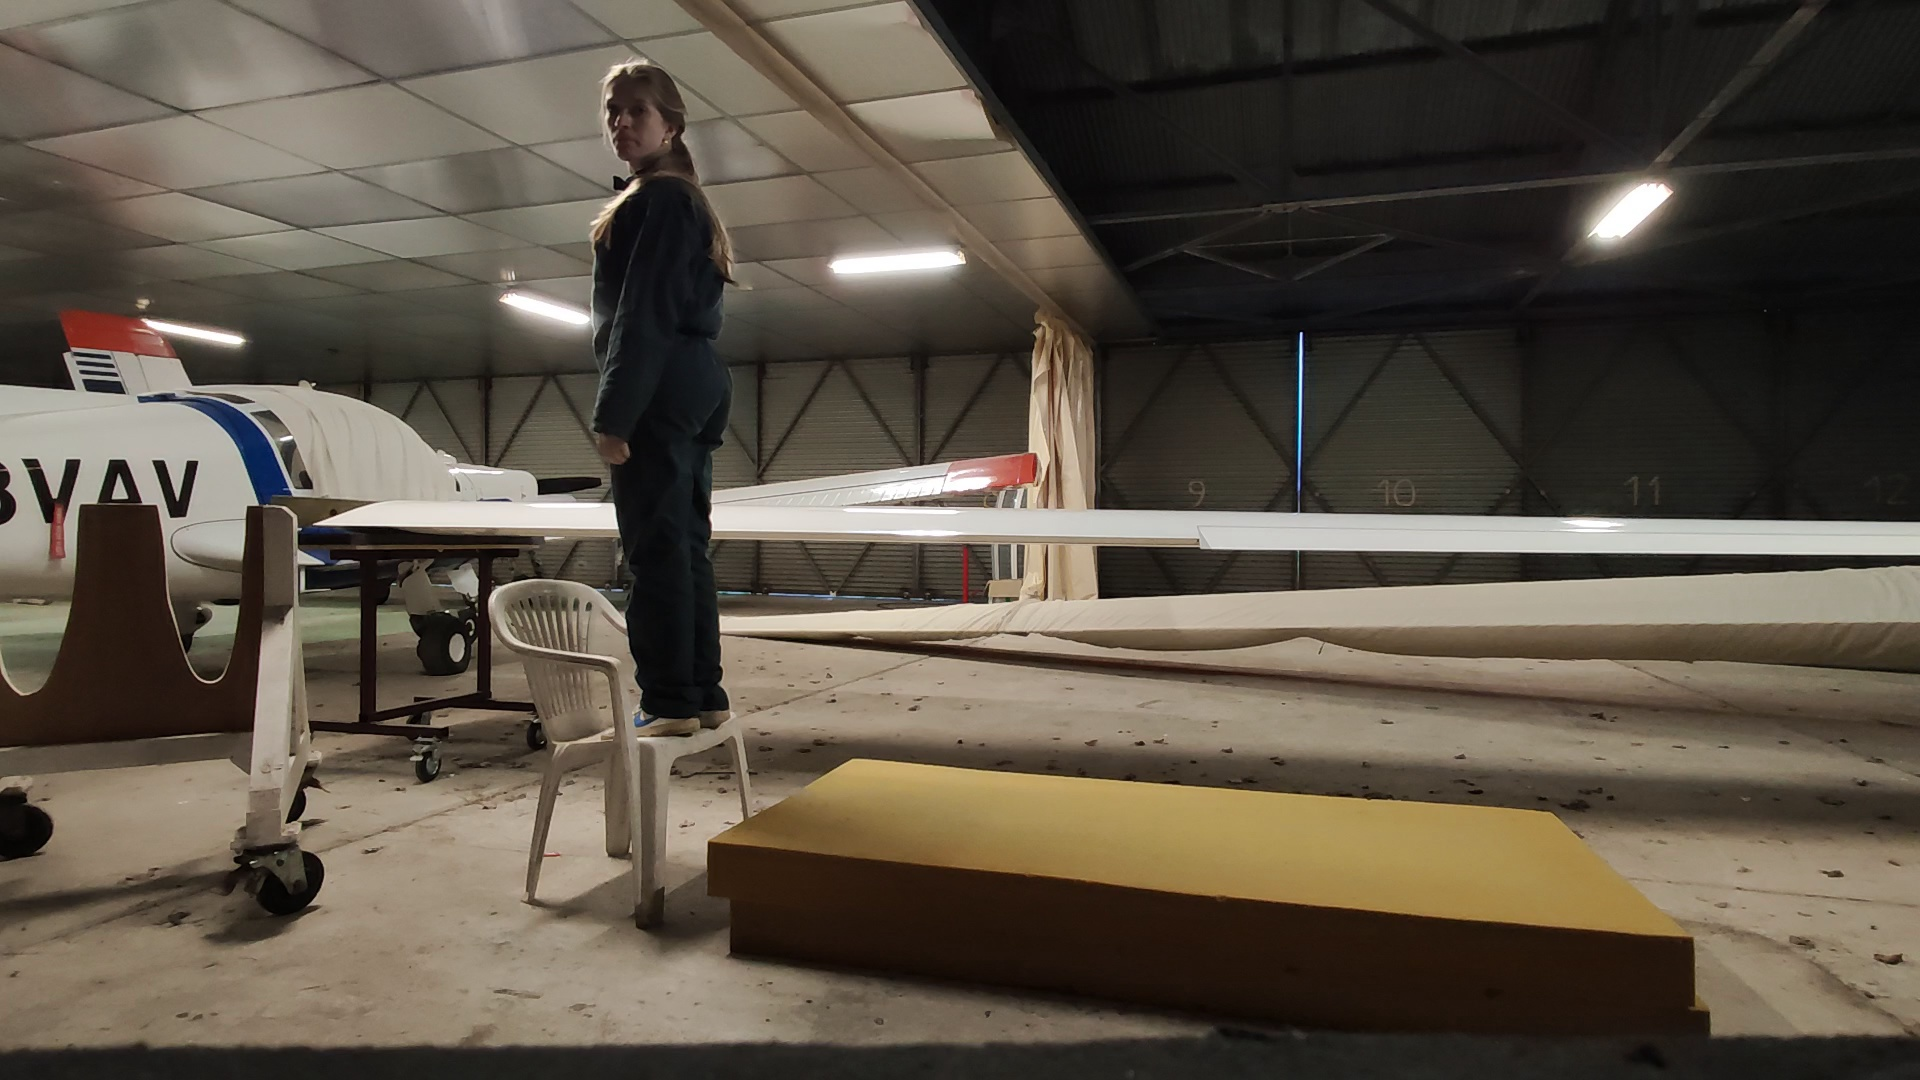

In [9]:
#Image importation
file_name = "first_frame.jpg"
img = cv.imread(file_name)
#20191124_134101_crop
#test_crop
#testyolov53
#falling5
#kevin2_crop
#girl_hips
#first_frame.jpg

#Name of the saved output file
output_file = "output.jpg"

#Display of the initial image
Image(filename=file_name) 

Video FPS: 25
Loading Inference Engine
Device info:
        CPU
        MKLDNNPlugin version ......... 2.1
        Build ........... 2021.4.2-3976-0943ed67223-refs/pull/539/head
Pose Detection model - Reading network files:
	models/movenet_multipose_lightning_192x256_FP32.xml
	models/movenet_multipose_lightning_192x256_FP32.bin
Input blob: input - shape: [1, 3, 192, 256]
Output blob: Identity - shape: [1, 6, 56]
Loading pose detection model into the plugin
Padding: Padding(w=0, h=360, padded_w=1920, padded_h=1440)
Started ....


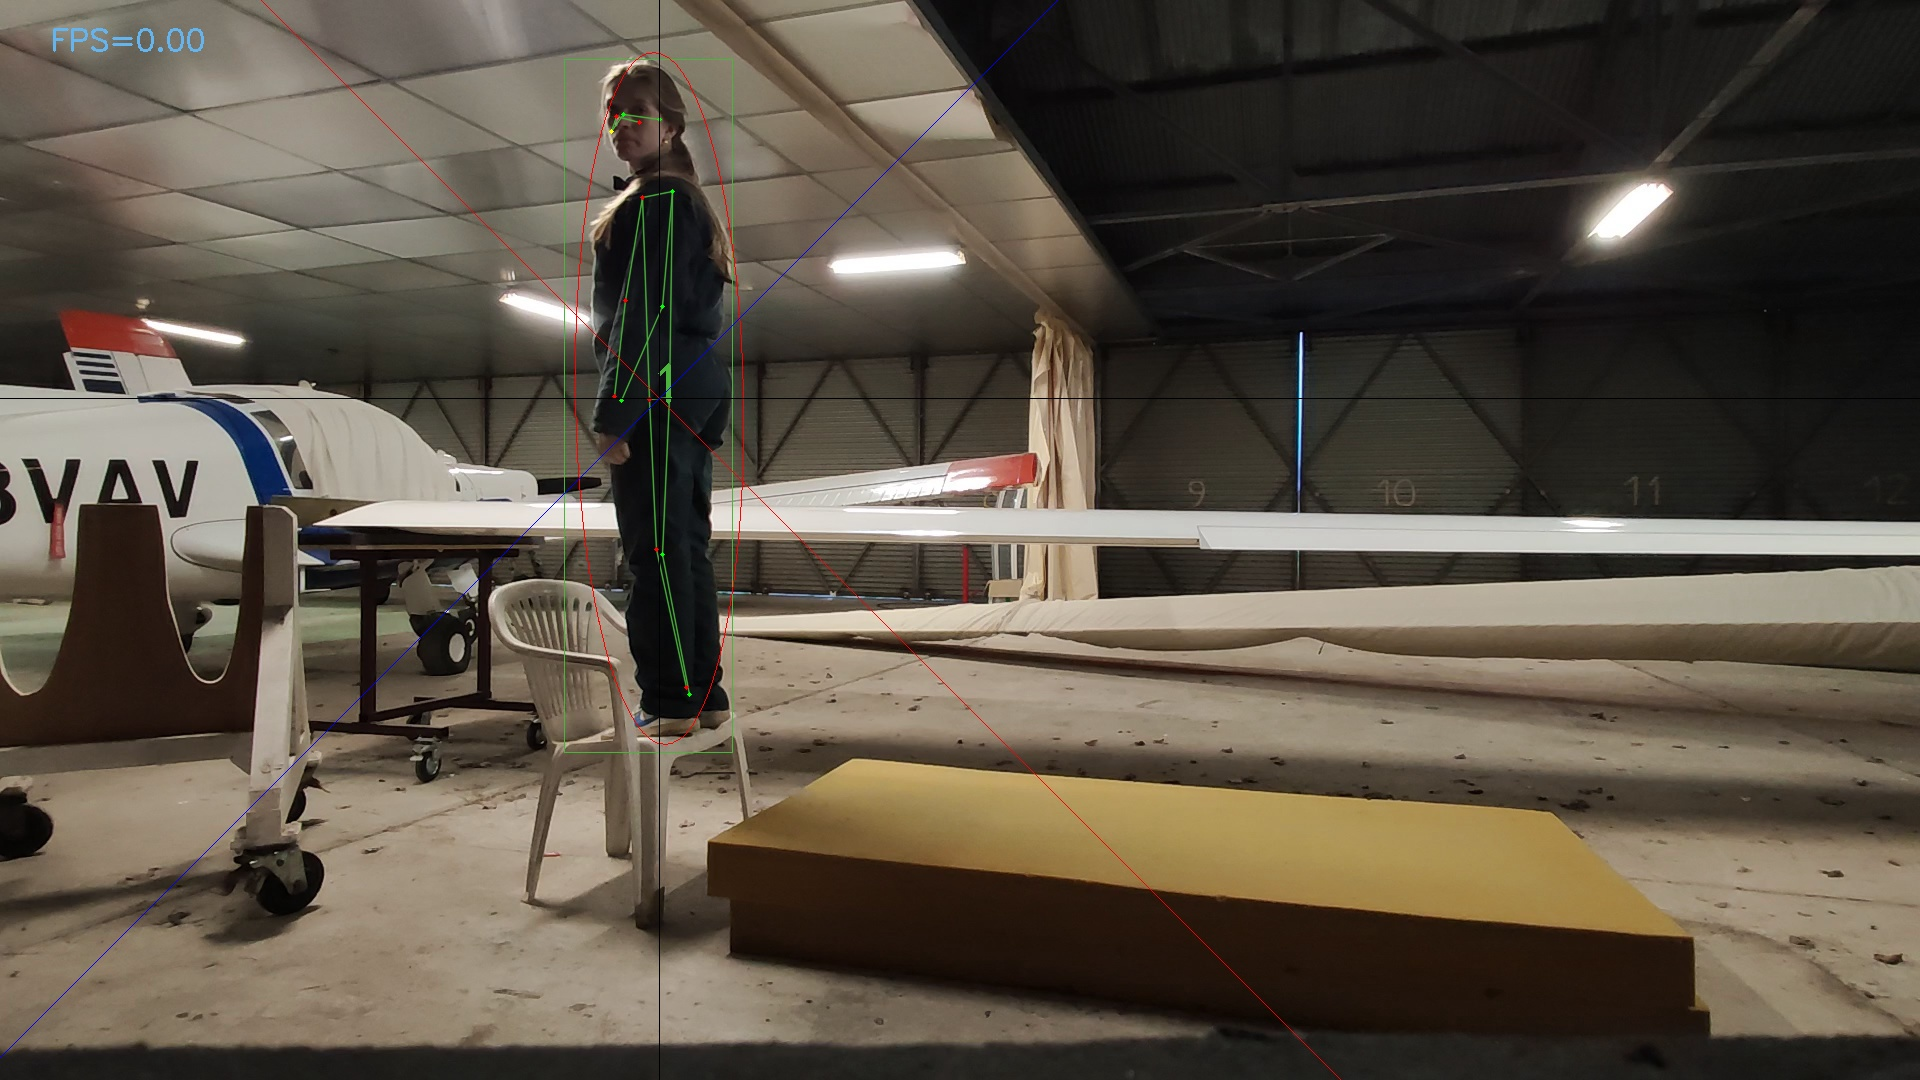

In [10]:
xml = DEFAULT_MODEL
score_thresh=0.1
pd = MovenetMPOpenvino(input_src= file_name,
            xml=DEFAULT_MODEL, 
            device="CPU",
            tracking="iou",  #iou oks None
            score_thresh=0.1,
            output= output_file)
bodies = pd.run()

#Display of the output image
Image(filename="output.jpg") 


In [11]:
print("Number of humans : ", len(bodies[0]))
nb_humans = len(bodies[0])

trackid = []
keypoints = []
x_min = []
x_max = []
y_min = []
y_max = []

#For every human in the picture we can save the parameters of each body
for i in range(len(bodies[0])) :
    trackid.append(bodies[0][i].track_id)
    keypoints.append(bodies[0][i].keypoints)
    x_min.append(bodies[0][i].xmin)
    x_max.append(bodies[0][i].xmax)
    y_max.append(bodies[0][i].ymax)
    y_min.append(bodies[0][i].ymin)

trackid = np.asarray(trackid)
keypoints = np.asarray(keypoints)  

print("KEYPOINT_DICT = {'nose': 0,'left_eye': 1,'right_eye': 2,'left_ear': 3,'right_ear': 4,'left_shoulder': 5,'right_shoulder': 6,'left_elbow': 7,'right_elbow': 8,'left_wrist': 9,'right_wrist': 10,'left_hip': 11,'right_hip': 12,'left_knee': 13,'right_knee': 14,'left_ankle': 15,'right_ankle': 16}",'\n')

#print(bodies[0].track_id)
#print(bodies[0][0].keypoints)
#print(bodies[0][0].keypoints_score.reshape(-1,1))

#print(bodies[0].keypoints)
#print(bodies[0].keypoints_norm)
#print(bodies[0].xmin)

Number of humans :  1
KEYPOINT_DICT = {'nose': 0,'left_eye': 1,'right_eye': 2,'left_ear': 3,'right_ear': 4,'left_shoulder': 5,'right_shoulder': 6,'left_elbow': 7,'right_elbow': 8,'left_wrist': 9,'right_wrist': 10,'left_hip': 11,'right_hip': 12,'left_knee': 13,'right_knee': 14,'left_ankle': 15,'right_ankle': 16} 



In [12]:
#Display of the keypoints, skeleton and bounding box of each human
frame = img
for i in range(0,nb_humans) :
    body = bodies[0][i]

    thickness = 1
    color_skeleton = (255, 180, 90)
    color_box = (0,255,255)

    LINES_BODY = [[4,2],[2,0],[0,1],[1,3],
                  [10,8],[8,6],[6,5],[5,7],[7,9],
                  [6,12],[12,11],[11,5],
                  [12,14],[14,16],[11,13],[13,15]]

    #Skeleton
    lines = [np.array([keypoints[i,point,:] for point in line]) for line in LINES_BODY if body.keypoints_score[line[0]] > score_thresh and body.keypoints_score[line[1]] > score_thresh]
    frame_keypoints = cv2.polylines(frame, lines, False, color_skeleton, 1, cv2.LINE_AA)
    
    #Keypoints
    for j,x_y in enumerate(keypoints[i,:,:]):
                    if body.keypoints_score[j] > score_thresh:
                        if j % 2 == 1:
                            color = (0,255,0) 
                        elif j == 0:
                            color = (0,255,255)
                        else:
                            color = (0,0,255)
                        cv2.circle(frame_keypoints, (x_y[0], x_y[1]), 2, color, -11)

    #Bounding box
    cv2.rectangle(frame_keypoints, (x_min[i], body.ymin), (body.xmax, body.ymax), color_box, thickness)

    # Display track_id at the center of the bounding box
    x_mid = (x_min[i] + x_max[i]) // 2
    y_mid = (y_min[i] + y_max[i]) // 2
    cv2.putText(frame_keypoints, str(body.track_id), (x_mid,y_mid), cv2.FONT_HERSHEY_PLAIN, 4, color_box, 3)

cv2.imshow("output",frame_keypoints)
cv2.waitKey(0)
cv2.destroyAllWindows() 

In [13]:
#Display of the regions and ellipses on each human
H = frame.shape[0]
W = frame.shape[1]

x = np.linspace(0,W,num = 500)
y = np.linspace(0,H,num = 500)

frame_rot = frame_keypoints

for i in range(0,nb_humans) :
    
    #Orientation of body (line)
    Neck = np.mean(keypoints[i,5:7,:],axis=0).reshape(1,2)[0]
    Hips = np.mean(keypoints[i,11:13,:],axis=0).reshape(1,2)[0]

    average_keypoints = np.concatenate((Neck,Hips),axis=0).reshape(2,2)

    coeff_vertical_rot = np.polyfit(average_keypoints[:,0], average_keypoints[:,1], 1)
    vertical_rot = f_inv(y,coeff_vertical_rot[0],coeff_vertical_rot[1])

    color = (0, 0, 255)
    cv2.line(frame_rot, (np.int64((np.round(vertical_rot[0],0))),np.int64((np.round(y[0],0)))),(np.int64((np.round(vertical_rot[-1],0))),np.int64((np.round(y[-1],0)))), color, thickness=1)

    alpha = np.radians(90) - math.atan(coeff_vertical_rot[0])
    print("Degrees of inclinaison of humans number ", trackid[i], " : ",np.round(np.degrees(alpha),2))
    
    #Rotated ellipse
    center_coordinates = (np.int64(Hips[0]), np.int64(Hips[1])) 
    if (x_max[i] - x_min[i]) <= (y_max[i] - y_min[i]) :
        axesLength = (np.int64((x_max[i] - x_min[i])/2), np.int64((y_max[i] - y_min[i])/2)) 
    else :
        axesLength = (np.int64((y_max[i] - y_min[i])/2), np.int64((x_max[i] - x_min[i])/2)) 

    angle = -np.round(np.degrees(alpha),2)
    color = (0, 0, 255) #BGR
    thickness = 1
    startAngle = 0
    endAngle = 360
    cv2.ellipse(frame_rot, center_coordinates, axesLength, angle, startAngle, endAngle, color, thickness)

    #Diagonals of the regions
    leftline = rotation(np.radians(45))@np.array([(Hips[0]*np.ones(len(x)) - Hips[0]),(y - Hips[1])]) + [np.ones(len(x))*Hips[0],np.ones(len(x))*Hips[1]]
    rightline = rotation(np.radians(-45))@np.array([(Hips[0]*np.ones(len(x)) - Hips[0]),(y - Hips[1])]) + [np.ones(len(x))*Hips[0],np.ones(len(x))*Hips[1]]
    coeff_left = np.polyfit(leftline[0], leftline[1], 1)
    coeff_right = np.polyfit(rightline[0], rightline[1], 1)

    leftline = np.concatenate((x.reshape(-1,1),f(x,coeff_left[0],coeff_left[1]).reshape(-1,1)),axis = 1)
    rightline =  np.concatenate((x.reshape(-1,1),f(x,coeff_right[0],coeff_right[1]).reshape(-1,1)), axis = 1)

    #Region plot
    color = (0,0,0)
    frame_regions = cv2.line(frame_keypoints, (np.int64((np.round(leftline[0,0],0))),np.int64((np.round(leftline[0,1],0)))),(np.int64((np.round(leftline[-1,0],0))),np.int64((np.round(leftline[-1,1],0)))), (0,0,255), thickness=1)
    cv2.line(frame_regions, (np.int64(Hips[0]),np.int64((np.round(y[0],0)))),(np.int64(Hips[0]),np.int64((np.round(y[-1],0)))), color, thickness=1)
    cv2.line(frame_regions, (np.int64((np.round(x[0],0))),np.int64(Hips[1])),(np.int64((np.round(x[-1],0))),np.int64(Hips[1])), color, thickness=1)
    cv2.line(frame_regions, (np.int64((np.round(rightline[0,0],0))),np.int64((np.round(rightline[0,1],0)))),(np.int64((np.round(rightline[-1,0],0))),np.int64((np.round(rightline[-1,1],0)))), (255,0,0), thickness=1)

cv2.imshow("output",frame_rot)
cv2.waitKey(0)
cv2.destroyAllWindows()
    
#cv2.imshow("output",frame_regions)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

Degrees of inclinaison of humans number  1  :  0.56


In [17]:
#Final NDH for each human
print(NDH(trackid,keypoints,W,H,'RegKey'))   #id, NDH

[[1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


# NDH in a video

In [99]:
#Video importation

#['walk', 'run', 'jump', 'legup', 'pickup', 'walk2', 'highfall', 'sitandup', 'movewithchair', 'fallchair', 'upsitbed', 'uplyingbed', 'fallbed']
#file_name = "C:/Users/SuperSoso1/Cranfield/GDP/DATA/Test_data/KinectData/S1/S1P19K6_fallbed_cut.mp4"
#file_name = 'C:/Users/SuperSoso1/Cranfield/GDP/DATA/Test_data/front_so_1.mp4'
#file_name = 'C:/Users/SuperSoso1/Cranfield/GDP/DATA/Falls_MoveNet/Fall_00016.mp4'

file_name = 'C:/Users/SuperSoso1/Cranfield/GDP/DATA/Test_data/CRANFIELD_test-data/Dongzi Camera/IMG_3777_Trim.mov'



#side.mp4
#VID_20220309_183957.mp4    Kevin hauteur
#VID_20220309_184558.mp4    Solène face
#VID_20220309_184709.mp4           dos
#VID_20220309_185143_2.mp4    Amor

#DATA/Test_data/KinectData/S1P19K1_fallbed_cut.mp4
#'side.mp4'
#'back_so_1.mp4'
#'back_so_2.mp4'
#'front_so_1.mp4'

#Fall_00008.mp4

#Name of the output video
output_file = 'C:/Users/SuperSoso1/Cranfield/GDP/DATA/Test_data/CRANFIELD_test-data/Dongzi Camera/' + (file_name.split('/')[-1]).split('.')[0] + '_keypoints.mp4'

1920
Video FPS: 29
Loading Inference Engine
Device info:
        CPU
        MKLDNNPlugin version ......... 2.1
        Build ........... 2021.4.2-3976-0943ed67223-refs/pull/539/head
Pose Detection model - Reading network files:
	models/movenet_multipose_lightning_192x256_FP32.xml
	models/movenet_multipose_lightning_192x256_FP32.bin
Input blob: input - shape: [1, 3, 192, 256]
Output blob: Identity - shape: [1, 6, 56]
Loading pose detection model into the plugin
Padding: Padding(w=0, h=360, padded_w=1920, padded_h=1440)
Started ....


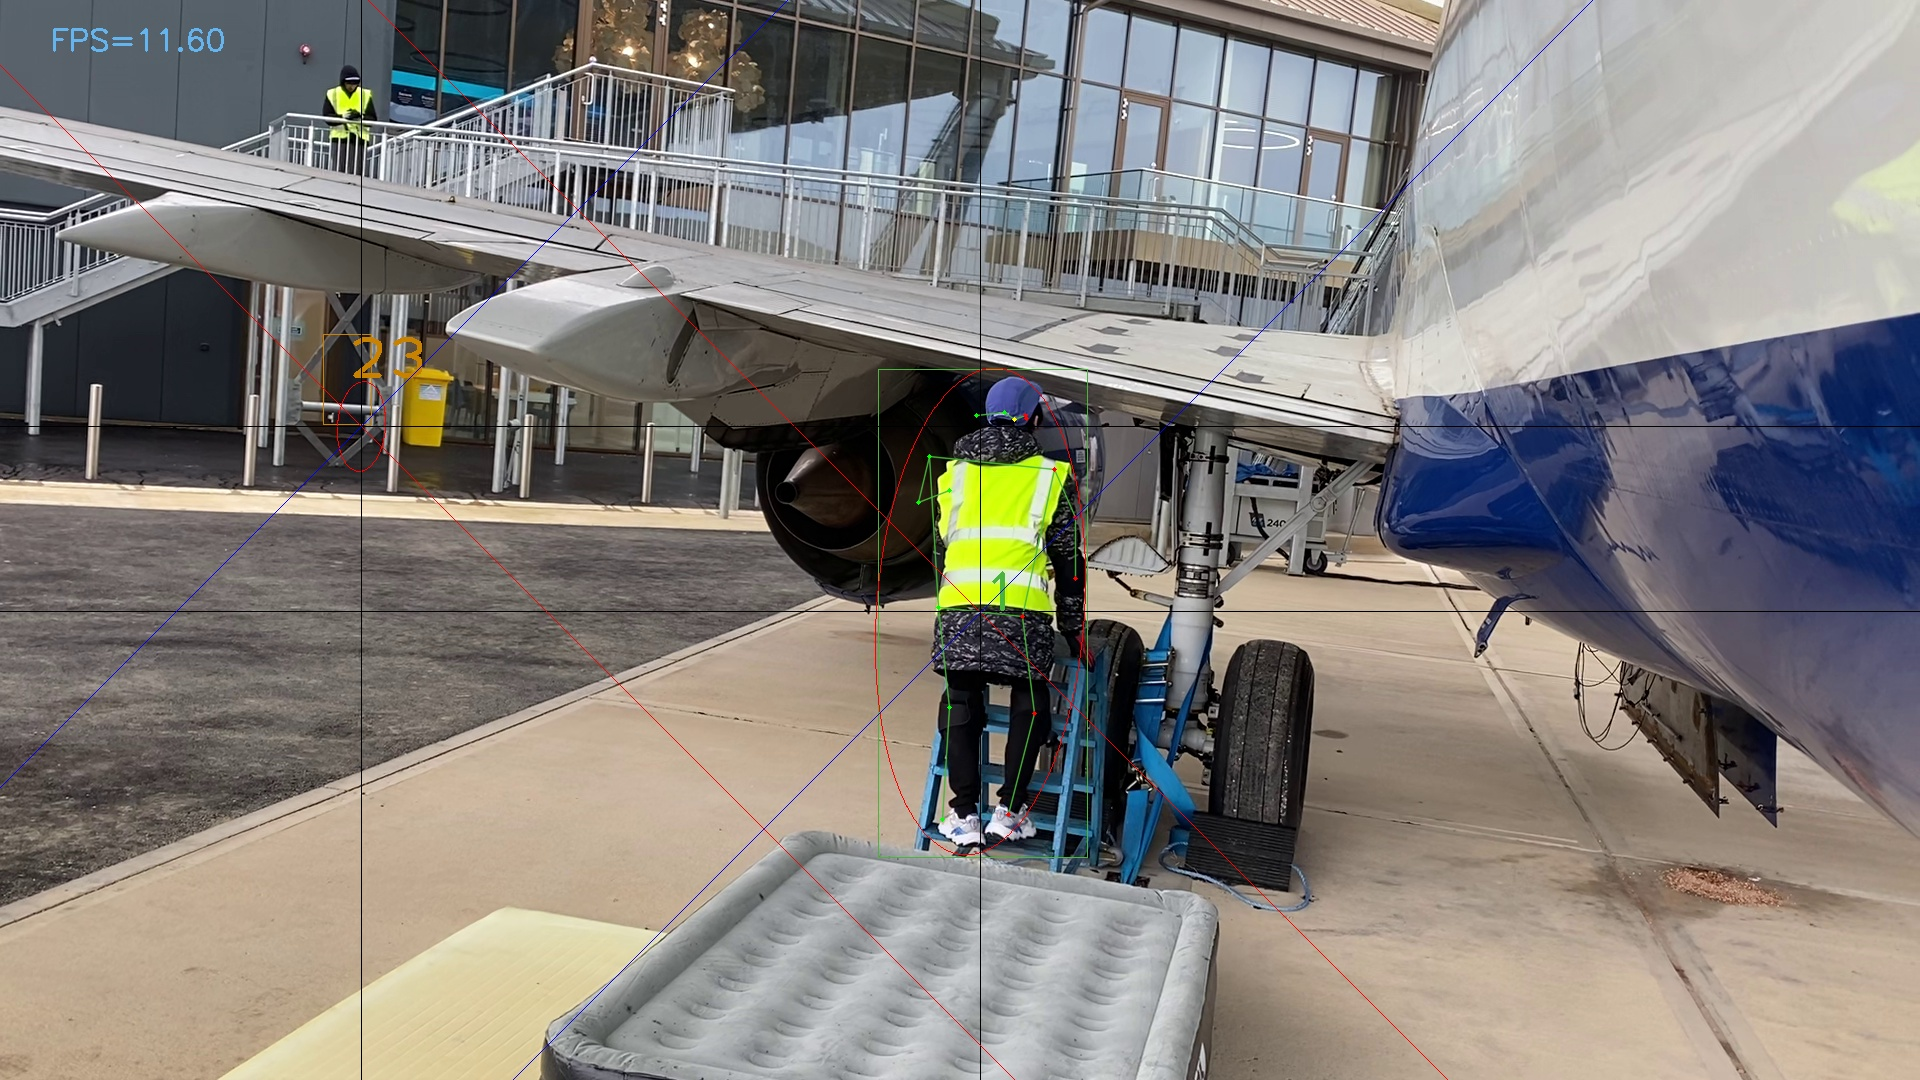

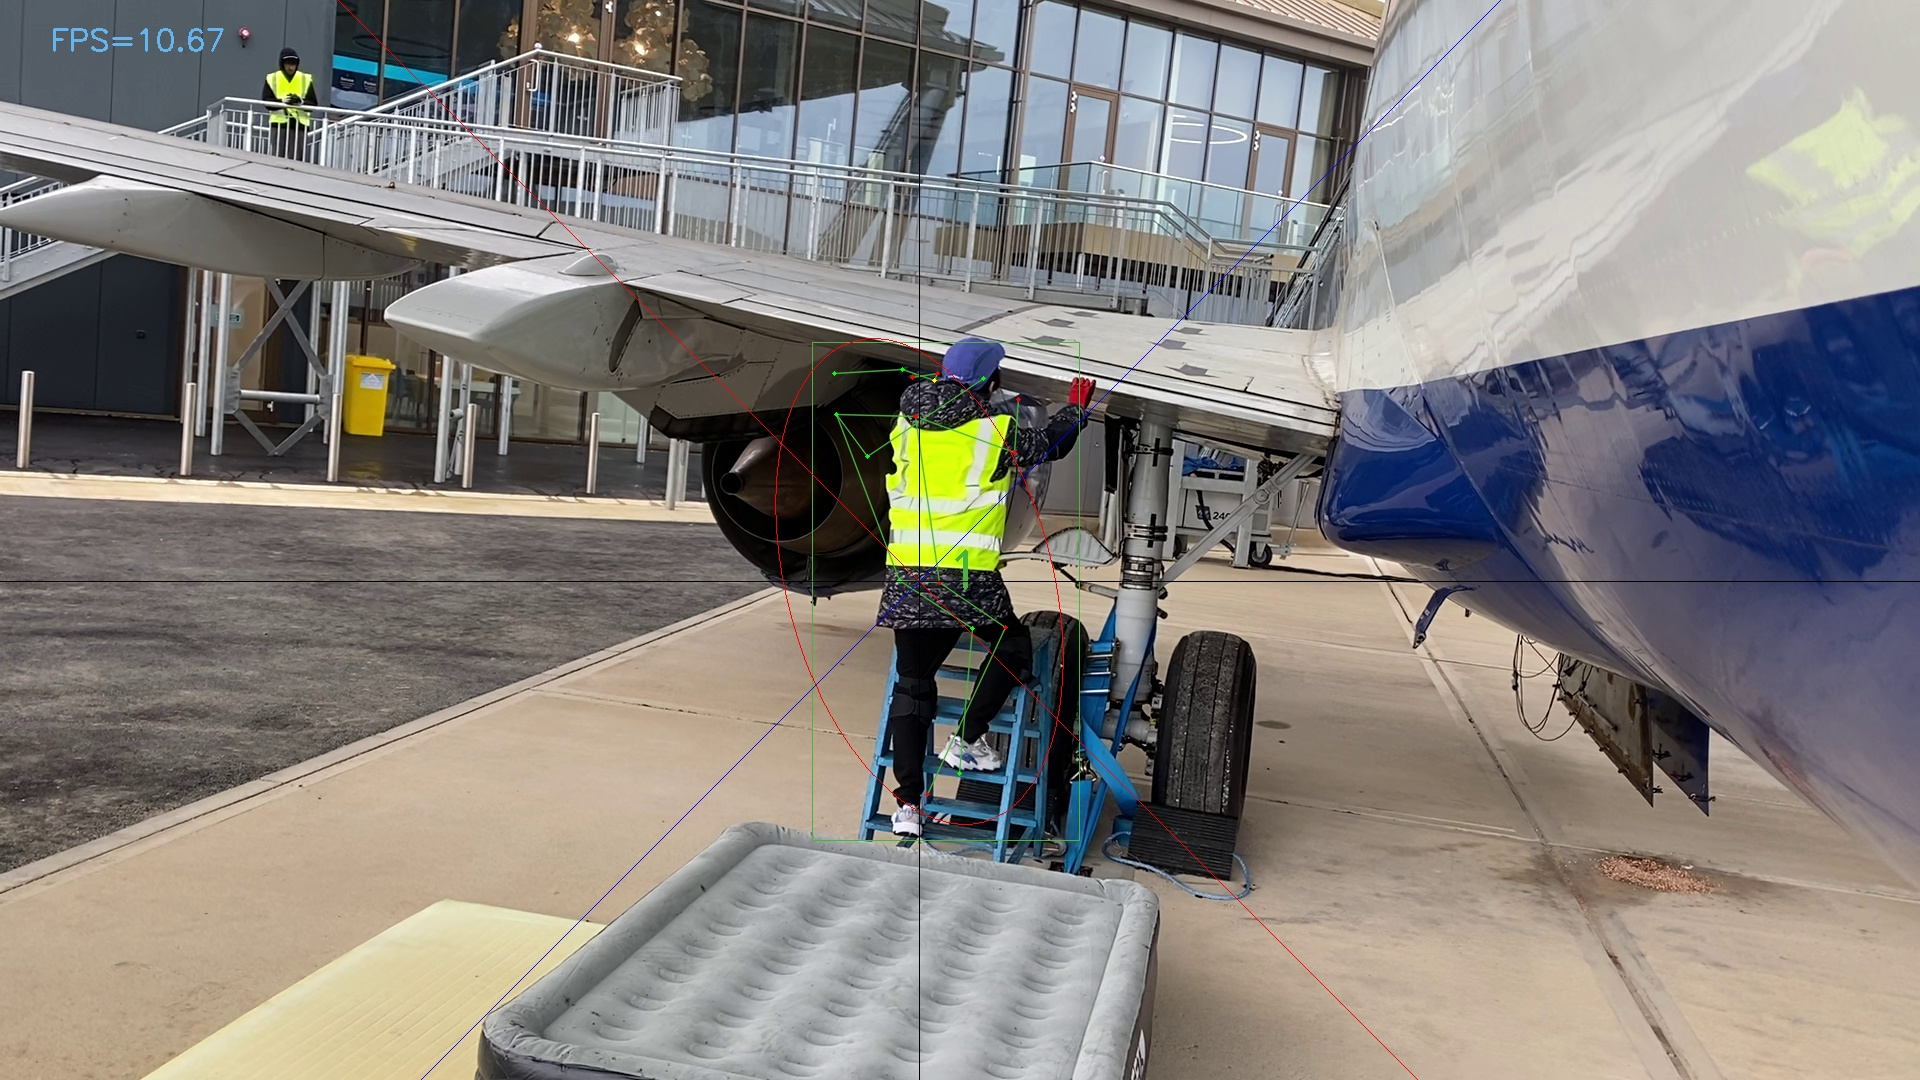

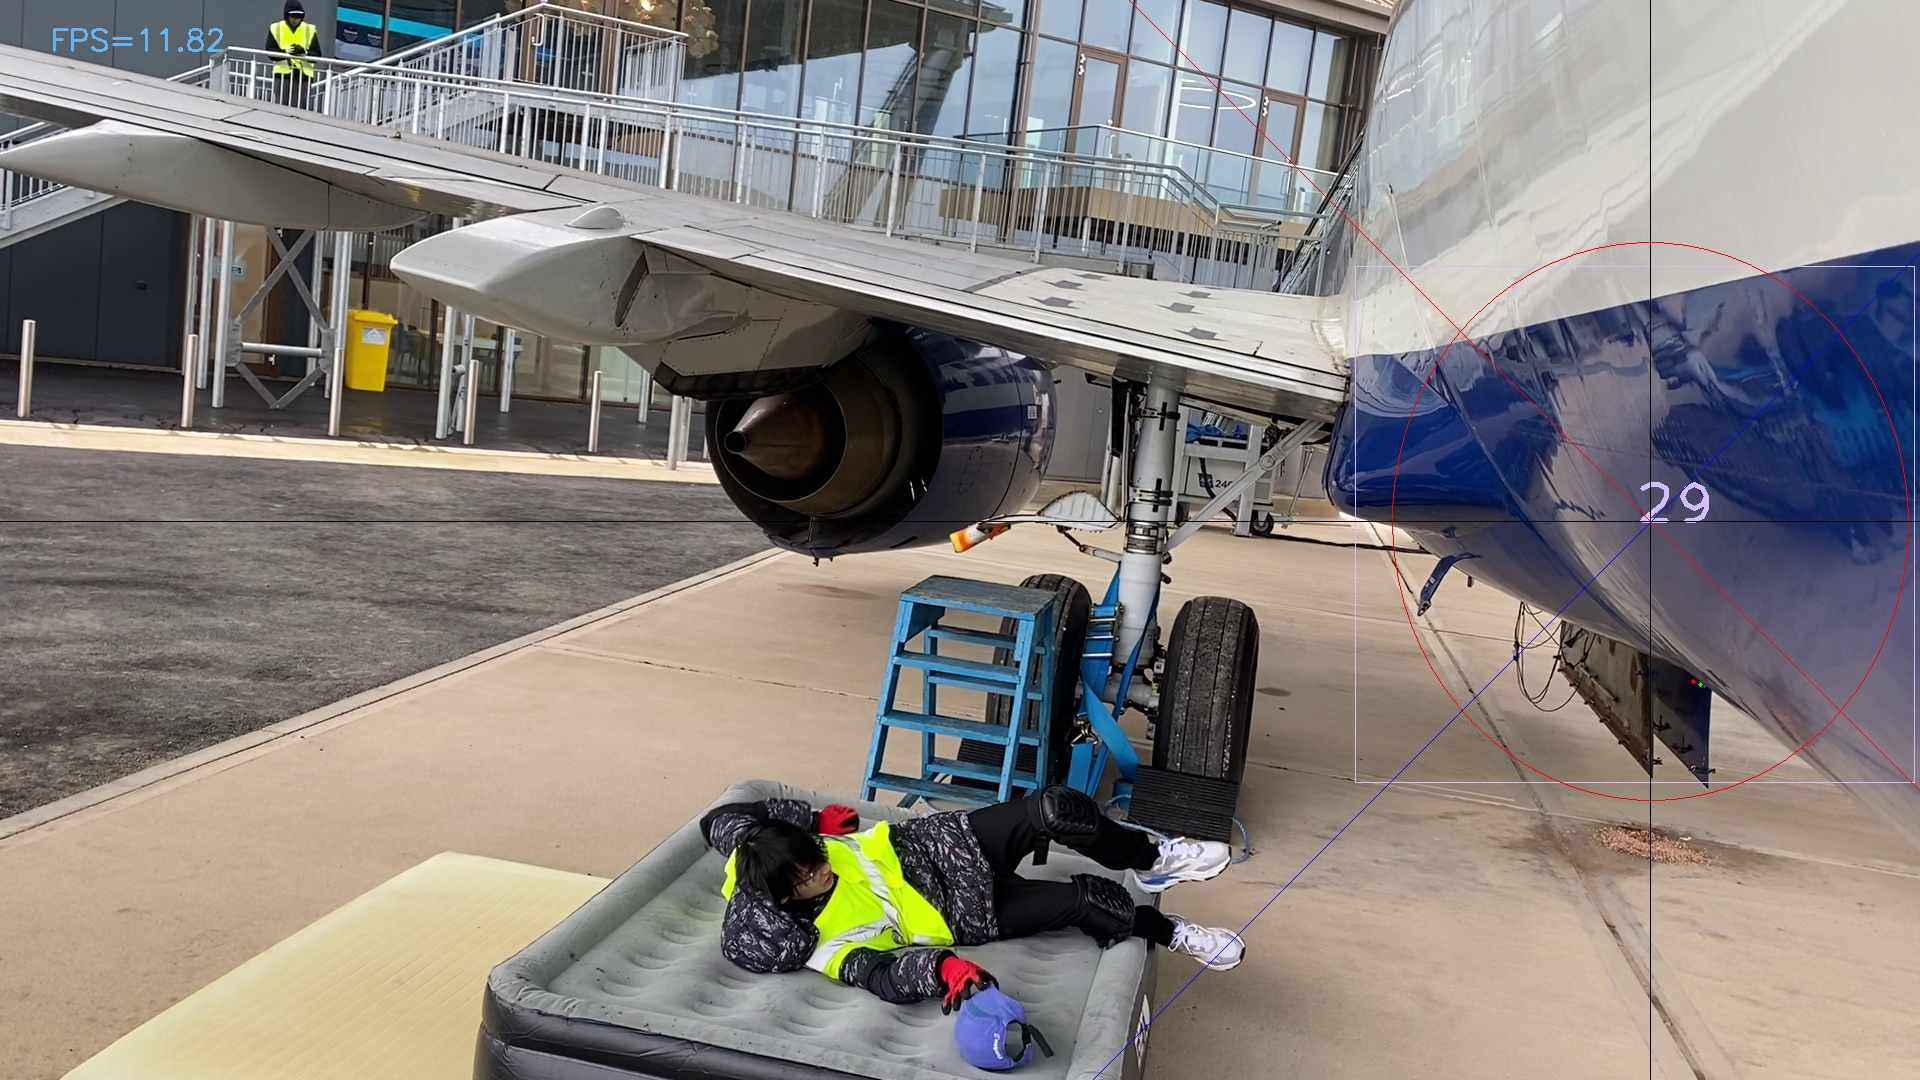

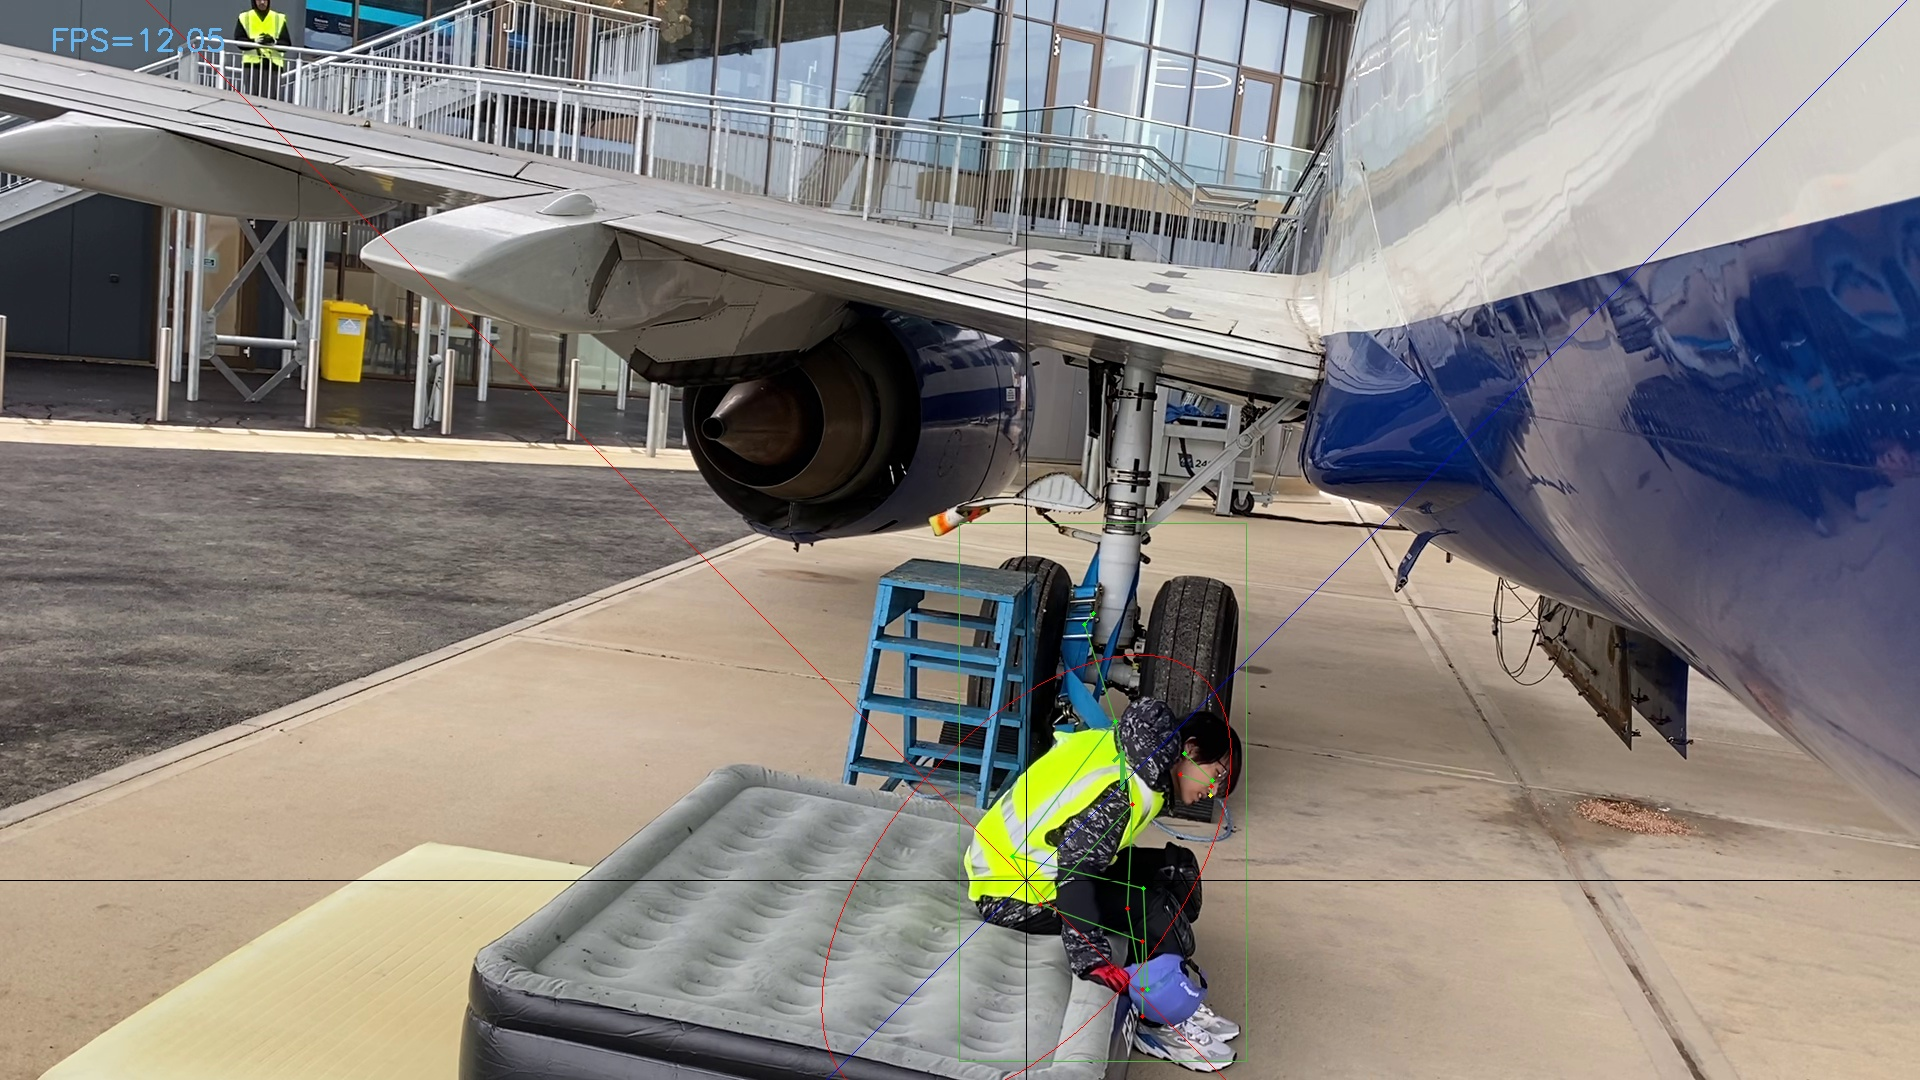

FPS : 11.1 f/s (# frames = 902)
# pose detection inferences : 902
Pose detection round trip   : 16.4 ms


In [100]:
xml = DEFAULT_MODEL
score_thresh=0.1
pd = MovenetMPOpenvino(input_src= file_name,
            xml=DEFAULT_MODEL, 
            device="CPU",
            tracking='iou',  #iou oks None
            score_thresh=0.1,
            output= output_file)
bodies = pd.run()

In [101]:
#For each frame
for i in range(len(bodies)) :
    
    #Creation of lists in the global list for each human in frame
    if (i == 0) :
        trackid = [[] for k in range(len(bodies[i]))]
        keypoints = [[] for k in range(len(bodies[i]))]
        x_min = [[] for k in range(len(bodies[i]))]
        x_max = [[] for k in range(len(bodies[i]))]
        y_min = [[] for k in range(len(bodies[i]))]
        y_max = [[] for k in range(len(bodies[i]))]
        
    #For each body in the frame (for each list)  
    for j in range(len(bodies[i])) :
        
        #If detection of an additional body : new list in list
        if (bodies[i][j].track_id > len(trackid)) :
            trackid.append([])
            keypoints.append([])
            x_min.append([])
            x_max.append([])
            y_max.append([])
            y_min.append([])
            
        #Append the parameters of each human in each frame in their specific list
        trackid[bodies[i][j].track_id - 1].append(bodies[i][j].track_id)
        keypoints[bodies[i][j].track_id - 1].append(bodies[i][j].keypoints)
        x_min[bodies[i][j].track_id - 1].append(bodies[i][j].xmin)
        x_max[bodies[i][j].track_id - 1].append(bodies[i][j].xmax)
        y_max[bodies[i][j].track_id - 1].append(bodies[i][j].ymax)
        y_min[bodies[i][j].track_id - 1].append(bodies[i][j].ymin)

In [102]:
print("Number of frames : ", len(bodies))
print("Number of humans detected : ", len(trackid),"\n")

h = len(trackid)

#"first_frame.jpg" is the first frame of the video that is always saved in the program's folder to have the dimensions
frame = cv.imread("first_frame.jpg")

H = frame.shape[0]
W = frame.shape[1]

#NDH for each human of the video
for i in range(0,h) :
    print(NDH(np.asarray(trackid[i]).reshape(-1,1),np.asarray(keypoints[i]),W,H,'RegKey'))
    
ndh_test = NDH(np.asarray(trackid[0]).reshape(-1,1),np.asarray(keypoints[0]),W,H,'RegKey')

Number of frames :  902
Number of humans detected :  34 

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]]
[[2. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[3. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 

[[14.  0.  0. ...  0.  0.  0.]
 [14.  0.  1. ...  0.  0.  0.]
 [14.  0.  1. ...  0.  0.  0.]
 ...
 [14.  0.  1. ...  0.  0.  0.]
 [14.  0.  0. ...  0.  0.  0.]
 [14.  0.  0. ...  0.  0.  0.]]
[[15.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.
   0.  0.  0.  0.  0.]
 [15.  1.  1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

[[20.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.
   0.  1.  1.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.
   0.  0.  0.  0.  0.]]
[[21.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.
   0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  1.  0.  0.  0.
   0.  0.  0.  0.  0.]]
[[22.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0

[[32.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.
   0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.
   1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.]
 [32.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.
   0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
   1.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.]]
[[33.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [103]:
np.savetxt((file_name).split('.')[0] +'_RegKey.csv', ndh_test, delimiter=",")